In [1]:
import os
from os import environ as ENV
ENV['CUDA_VISIBLE_DEVICES'] = '0'
ROOT = ENV['PWD']

import scipy
from scipy.special import expit as sigmoid
import jax.numpy as jnp
import jax
import numpy as np
import numpy.typing as npt
Float = np.float64

from itertools import combinations
from tqdm.notebook import tqdm

print(jax.devices())
jax.config.update("jax_enable_x64", True)

import pennylane as qml
dev = qml.device("lightning.gpu", wires=18)

[cuda(id=0)]


In [2]:
TESTING = False

In [3]:
# pennylane-catalyst uv/venv metagarbage
import catalyst
# https://github.com/PennyLaneAI/catalyst/pull/1839
# catalyst.utils.runtime_environment.get_cli_path = lambda: ENV['PWD'] + '/.venv/bin/catalyst'
catalyst.utils.runtime_environment.get_cli_path()

'/home/user/work/quadrigems/.venv/bin/catalyst'

In [4]:
# remember to delete cache when rewriting function
import diskcache as dc
cache = dc.Cache(
    ROOT + '/.cache/pennylane_sim/',
    size_limit = 2 ** 32, # 4GB
)

In [5]:
import sys
sys.path.append('..')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *

In [13]:
# if either is the 0 vector, then norm is undefined. unlikely to occur
@qml.qjit(seed=0)
@qml.qnode(dev)
def swap_circuit(data1:npt.NDArray[Float], data2:npt.NDArray[Float], norm:bool=True) -> npt.NDArray[Float]:
    l1, l2 = len(data1), len(data2)
    assert l1 == l2

    # data embedding
    qml.AngleEmbedding(data1, wires=range(l1))
    qml.AngleEmbedding(data2, wires=range(l1, l1+l2))

    # # QFT is inv DFT; inv QFT is DFT
    # qml.adjoint(
    qml.QFT(wires = range(l1))
    # )
    # qml.adjoint(
    qml.QFT(wires = range(l1, l1 + l2))
    # )

    # Swap test
    for i in range(l1):
        qml.CNOT(wires = [i, l1 + i])
    qml.Barrier()
    for i in range(l1):
        qml.H(i)

    return qml.probs(wires = range(l1 + l2))

In [14]:
def rescale(x):
    return sigmoid(x / np.linalg.norm(x, ord=1)) * np.pi/2

In [15]:
#fast enough to compute w/o caching


from time import time as now

# don't cache while debugging
# @cache.memoize()
def get_fidelity_memo(data1:list[int], data2:list[int]) -> tuple[Float,Float]:
    probs = swap_circuit(data1, data2)
    _, fidelity = swap_expectation(probs, len(data1))
    mean = np.mean(np.array(probs)) # circuit exp value
    return mean, fidelity

def get_fidelity(data1:list[int], data2:list[int]) -> tuple[Float,Float]:
    # data1 should be less than data2
    if is_array_lesser(data2, data1):
        return get_fidelity(data2, data1)
    # normalize data
    data1 = rescale(data1) # sigmoid(data1 / np.linalg.norm(data1, ord=1)) * np.pi/2
    data2 = rescale(data2) # sigmoid(data2 / np.linalg.norm(data2, ord=1)) * np.pi/2
    # print(data1 == data2)
    return get_fidelity_memo(data1, data2)

In [16]:
# should get 1
a = np.array([2,2,2, 2,2,2, 2,2,2,], dtype=Float)
b = np.array([2,2,2, 2,2,2, 2,2,2,], dtype=Float)
c = np.array([3]*9, dtype=Float)
#normalization will make these equal to each other

In [17]:
print(a.dtype)

float64


In [18]:
print('Drawing')
print(qml.draw(swap_circuit)(rescale(a), rescale(c)))

Drawing
 0: ─╭AngleEmbedding(M0)─╭QFT─╭●──────────────────────────||──H─┤ ╭Probs
 1: ─├AngleEmbedding(M0)─├QFT─│──╭●───────────────────────||──H─┤ ├Probs
 2: ─├AngleEmbedding(M0)─├QFT─│──│──╭●────────────────────||──H─┤ ├Probs
 3: ─├AngleEmbedding(M0)─├QFT─│──│──│──╭●─────────────────||──H─┤ ├Probs
 4: ─├AngleEmbedding(M0)─├QFT─│──│──│──│──╭●──────────────||──H─┤ ├Probs
 5: ─├AngleEmbedding(M0)─├QFT─│──│──│──│──│──╭●───────────||──H─┤ ├Probs
 6: ─├AngleEmbedding(M0)─├QFT─│──│──│──│──│──│──╭●────────||──H─┤ ├Probs
 7: ─├AngleEmbedding(M0)─├QFT─│──│──│──│──│──│──│──╭●─────||──H─┤ ├Probs
 8: ─╰AngleEmbedding(M0)─╰QFT─│──│──│──│──│──│──│──│──╭●──||──H─┤ ├Probs
 9: ─╭AngleEmbedding(M0)─╭QFT─╰X─│──│──│──│──│──│──│──│───||────┤ ├Probs
10: ─├AngleEmbedding(M0)─├QFT────╰X─│──│──│──│──│──│──│───||────┤ ├Probs
11: ─├AngleEmbedding(M0)─├QFT───────╰X─│──│──│──│──│──│───||────┤ ├Probs
12: ─├AngleEmbedding(M0)─├QFT──────────╰X─│──│──│──│──│───||────┤ ├Probs
13: ─├AngleEmbedding(M0)─├QFT─────────────╰

In [19]:
exp_swap, fidelity = get_fidelity(a, b)
exp_swap, fidelity

(np.float64(3.8146972656249763e-06), Array(1., dtype=float64))

# run simulated results on significant neurons of smallest recording

In [20]:
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons]
coords = get_coords(record).loc[sig_neurons]

In [21]:
try:
    0/0
    quantum_fidelity = pd.read_csv(ROOT + '/data/quantum_fidelity.csv')

except:
    quantum_fidelity = pd.DataFrame(columns = ['A', 'B', 'exp_value', 'fidelity'])

    # A x B
    pairs, pairs_len = combinations(sig_neurons, 2), (len(sig_neurons) * (len(sig_neurons) - 1) // 2)
    for a, b in tqdm(pairs, total=pairs_len):
        a_i, b_i = tuning_curves.loc[a], tuning_curves.loc[b]
        exp_value, fidelity = get_fidelity(a_i, b_i)
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, b, exp_value, fidelity]
        quantum_fidelity.loc[len(quantum_fidelity)] = [b, a, exp_value, fidelity]

    # A x A
    # for sanity checking
    for a in tqdm(sig_neurons):
        a_i = tuning_curves.loc[a]
        exp_value, fidelity = get_fidelity(a_i, a_i)
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, a, exp_value, fidelity]

    quantum_fidelity.to_csv(ROOT + '/data/quantum_fidelity.csv')


  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [22]:
quantum_fidelity_matrix = quantum_fidelity.pivot_table(index = 'A', columns = 'B')['fidelity']

In [23]:
quantum_exp_matrix = quantum_fidelity.pivot_table(index = 'A', columns = 'B')['exp_value']

In [24]:
quantum_fidelity_matrix[23][32]

0.9989617992051327

In [31]:
quantum_fidelity_matrix

B,23,32,35,36,37,50,53,55,57,59,...,411,416,419,420,421,424,425,426,428,435
A,,,,,,,,,,,,,,,,,,,,,
23,1.0,0.998962,0.999894,0.999726,0.999878,0.999914,0.999934,0.999942,0.999924,0.999845,...,0.999876,0.999808,0.999712,0.999715,0.999496,0.99964,0.999939,0.999843,0.999886,0.999822
32,0.998962,1.0,0.999145,0.999353,0.999444,0.999315,0.999261,0.999177,0.999126,0.999398,...,0.999484,0.999493,0.999437,0.999383,0.998403,0.998659,0.999216,0.999393,0.999271,0.999433
35,0.999894,0.999145,1.0,0.999774,0.999868,0.999937,0.999965,0.999913,0.999883,0.999942,...,0.999906,0.999893,0.999756,0.999793,0.999317,0.99946,0.999966,0.999842,0.999922,0.999896
36,0.999726,0.999353,0.999774,1.0,0.999787,0.999736,0.999855,0.999716,0.999632,0.999812,...,0.99982,0.999811,0.999726,0.999692,0.998829,0.999358,0.999777,0.999769,0.999744,0.999871
37,0.999878,0.999444,0.999868,0.999787,1.0,0.999949,0.999952,0.999907,0.999921,0.999943,...,0.999952,0.999956,0.999803,0.999837,0.99948,0.999526,0.999924,0.999927,0.999924,0.999951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.99964,0.998659,0.99946,0.999358,0.999526,0.999656,0.999525,0.99972,0.999632,0.999335,...,0.999521,0.99929,0.999341,0.99904,0.999184,1.0,0.999547,0.999599,0.999286,0.999375
425,0.999939,0.999216,0.999966,0.999777,0.999924,0.999973,0.999976,0.999951,0.99996,0.99995,...,0.999928,0.999927,0.999855,0.999818,0.999478,0.999547,1.0,0.999845,0.999928,0.999911
426,0.999843,0.999393,0.999842,0.999769,0.999927,0.999898,0.999899,0.99986,0.999802,0.999875,...,0.999955,0.999837,0.999595,0.999702,0.999226,0.999599,0.999845,1.0,0.999868,0.999906


In [32]:
quantum_exp_matrix

B,23,32,35,36,37,50,53,55,57,59,...,411,416,419,420,421,424,425,426,428,435
A,,,,,,,,,,,,,,,,,,,,,
23,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
32,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
35,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
36,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
37,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
425,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
426,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004


In [33]:
from PIL import Image
import matplotlib.pyplot as plt

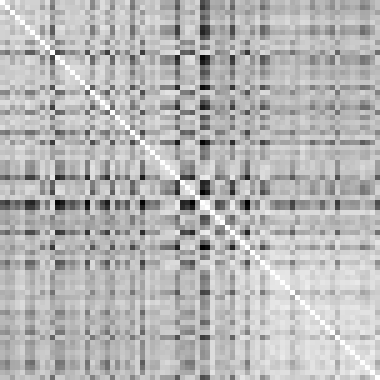

In [34]:
q_exp_corr = pd.DataFrame(quantum_exp_matrix).corr().to_numpy()
Image.fromarray(
    (q_exp_corr * 255).astype(np.uint8),
    mode = 'L'
).resize((len(sig_neurons) * 5, len(sig_neurons) * 5), Image.NEAREST).show()

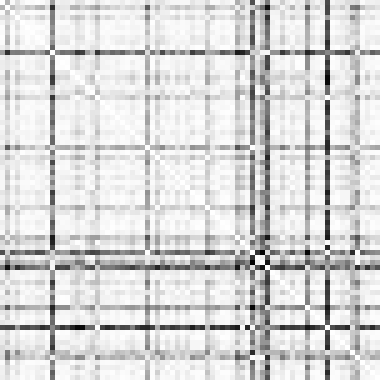

In [35]:
q_fidelity_corr = pd.DataFrame(quantum_fidelity_matrix).corr().to_numpy()
Image.fromarray(
    (q_fidelity_corr * 255).astype(np.uint8),
    mode = 'L'
).resize((len(sig_neurons) * 5, len(sig_neurons) * 5), Image.NEAREST).show()

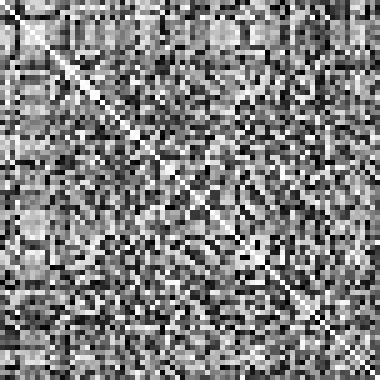

In [36]:
corrs = tuning_curves.T.corr().to_numpy()
Image.fromarray(
    (corrs * 255).astype(np.uint8),
    mode = 'L'
).resize((len(sig_neurons) * 5, len(sig_neurons) * 5), Image.NEAREST).show()

In [37]:
# classical euclidean distance
def euclidean(a,b):
    return np.linalg.norm(a-b)

classical_distance = pd.DataFrame(columns = ['A', 'B', 'euclidean'])

 # A x B
pairs, pairs_len = combinations(sig_neurons, 2), (len(sig_neurons) * (len(sig_neurons) - 1) // 2)
for a, b in pairs:
    a_i, b_i = tuning_curves.loc[a], tuning_curves.loc[b]
    dist = euclidean(a_i, b_i)
    # print(dist)
    classical_distance.loc[len(classical_distance)] = [a, b, dist]
    classical_distance.loc[len(classical_distance)] = [b, a, dist]

# # A x A
# # for sanity checking
for a in sig_neurons:
    a_i = tuning_curves.loc[a]
    dist = euclidean(a_i, a_i)
    classical_distance.loc[len(classical_distance)] = [a, a, dist]

In [38]:
classical_distance['euclidean'][0]

np.float64(57.489713065330626)

In [39]:
classical_distance_matrix = classical_distance.pivot_table(index = 'A', columns = 'B')['euclidean']

In [40]:
classical_distance_matrix

B,23.0,32.0,35.0,36.0,37.0,50.0,53.0,55.0,57.0,59.0,...,411.0,416.0,419.0,420.0,421.0,424.0,425.0,426.0,428.0,435.0
A,,,,,,,,,,,,,,,,,,,,,
23.0,0.000000,57.489713,15.673022,32.390285,17.576971,12.735483,13.170797,15.677175,20.828368,18.432809,...,15.311713,32.906094,25.817023,22.904627,336.287309,65.497791,11.533044,24.211957,18.424718,22.689595
32.0,57.489713,0.000000,52.771415,45.990628,43.804962,49.948916,53.508839,51.272857,52.756258,45.874278,...,45.945187,41.249058,43.507421,49.629841,334.668219,80.574786,51.126581,44.575297,48.862794,43.555141
35.0,15.673022,52.771415,0.000000,28.440559,17.716748,13.395683,15.574955,15.496736,20.206583,11.595409,...,15.977783,25.781608,23.608061,22.647838,334.466514,66.496907,8.835821,22.395968,14.465426,17.073113
36.0,32.390285,45.990628,28.440559,0.000000,27.189350,32.965551,32.683349,29.776658,33.516520,26.892119,...,30.267146,25.852305,29.264449,36.228114,332.619011,62.836156,28.939034,27.007108,28.905031,21.192116
37.0,17.576971,43.804962,17.716748,27.189350,0.000000,13.640350,17.909171,15.565263,16.759792,11.809627,...,13.939224,20.453064,21.348063,21.837044,330.222239,63.594681,13.638144,15.925541,13.971873,11.791310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424.0,65.497791,80.574786,66.496907,62.836156,63.594681,66.432092,73.810065,55.252345,55.002961,70.057234,...,69.993030,63.793526,67.841486,81.304534,296.560043,0.000000,65.370300,56.711613,69.003652,65.896650
425.0,11.533044,51.126581,8.835821,28.939034,13.638144,9.017099,13.179892,13.043485,15.884670,10.537249,...,13.394874,25.088487,18.430763,20.454258,333.458332,65.370300,0.000000,22.819565,14.340762,16.419648
426.0,24.211957,44.575297,22.395968,27.007108,15.925541,22.629235,27.060906,19.935004,23.849603,20.674766,...,20.106911,24.971405,32.891454,32.513397,328.410373,56.711613,22.819565,0.000000,19.888270,16.764802


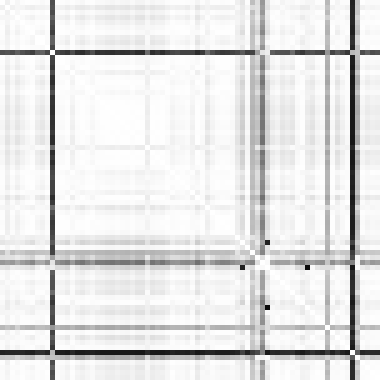

In [41]:
euclidean_corr = classical_distance_matrix.corr().to_numpy()
Image.fromarray(
    (euclidean_corr * 255).astype(np.uint8),
    mode = 'L'
).resize((len(sig_neurons) * 5, len(sig_neurons) * 5), Image.NEAREST).show()

In [ ]:
_ = plt.hist(qf_z)
_ = plt.title('Angle Encoding → QFT → SWAP → Overlap')

In [ ]:
plt.violinplot(qf_z.reshape((qf_z.size,)), orientation='horizontal', showmeans=True)

similar distributions? with harmonic-ish stuff in research
- [superoscillations](https://www.semanticscholar.org/paper/Super-oscillation-by-higher-order-radially-beams-Matsunaga-Kozawa/0784f24ec848c9e2fa002c7806de992859977ee1)
- [higher-order gaussian](https://www.researchgate.net/figure/The-normalized-intensity-distribution-of-hollow-higher-order-cosh-Gaussian-beams-at-the_fig1_347963556)

# TODO

- memoize functions
- run on GPU
- run on QPU (no mitigation)
- run on QPU (with Mitiq)
- end to end analysis